In [1]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [2]:
gpu_device = tf.config.experimental.list_physical_devices('GPU')
print(f"Number of GPU = {len(gpu_device)}")
tf.config.experimental.set_memory_growth(gpu_device[0], True)

Number of GPU = 1


In [3]:
SEED = 1000
IMG_SIZE = 224
BATCH_SIZE = 64

TRAIN_DIR = 'C:/Users/Ankur Saha/Thesis/archive/Train'

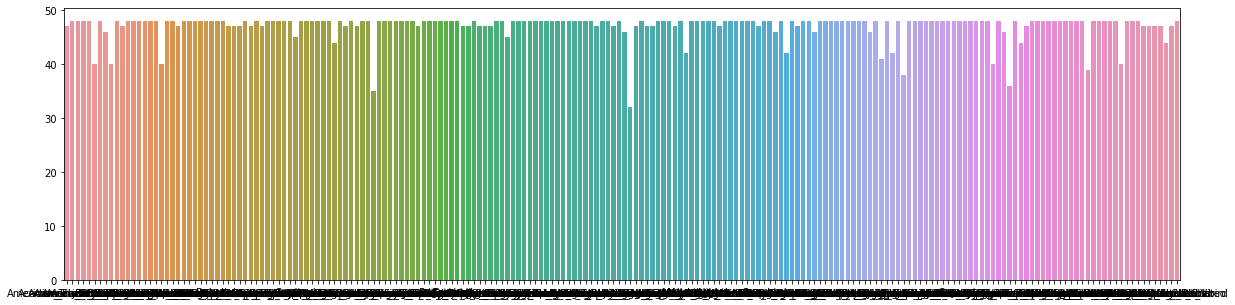

In [4]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
  files = gb.glob(pathname=str(TRAIN_DIR + "//" + f + "/*"))
  class_names.append(f)
  class_count.append(len(files))
  train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.show()

In [7]:
train_gen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3
)

In [8]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode = 'categorical',
    seed=SEED
)

Found 6662 images belonging to 200 classes.


In [9]:
valid_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode = 'categorical',
    seed=SEED
)

Found 2752 images belonging to 200 classes.


In [10]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [12]:
base_model.trainable = False

In [13]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(2048, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.Dropout(0.4)(x)


outputs = tf.keras.layers.Dense(200, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2048)              2623488   
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                             

In [15]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9),
#     optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
#     loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.02, patience=10, restore_best_weights=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001, verbose=1)

C:\Users\Ankur Saha\.conda\envs\CVPR\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [16]:
h = model.fit(train_batch, 
              epochs=100,
              steps_per_epoch = 6662 // BATCH_SIZE,
              validation_data = valid_batch,
              validation_steps = 2752 // BATCH_SIZE,
              callbacks=[cb, reduce_lr]
             )

Epoch 1/100
104/104 [==============================] - 79s 704ms/step - loss: 5.7676 - accuracy: 0.0074 - val_loss: 5.3060 - val_accuracy: 0.0094 - lr: 1.0000e-04
Epoch 2/100
104/104 [==============================] - 74s 717ms/step - loss: 5.5436 - accuracy: 0.0123 - val_loss: 5.2457 - val_accuracy: 0.0196 - lr: 1.0000e-04
Epoch 3/100
104/104 [==============================] - 73s 700ms/step - loss: 5.3161 - accuracy: 0.0230 - val_loss: 5.0923 - val_accuracy: 0.0305 - lr: 1.0000e-04
Epoch 4/100
104/104 [==============================] - 74s 709ms/step - loss: 5.1217 - accuracy: 0.0324 - val_loss: 4.9146 - val_accuracy: 0.0491 - lr: 1.0000e-04
Epoch 5/100
104/104 [==============================] - 73s 701ms/step - loss: 4.9386 - accuracy: 0.0506 - val_loss: 4.7460 - val_accuracy: 0.0665 - lr: 1.0000e-04
Epoch 6/100
104/104 [==============================] - 74s 710ms/step - loss: 4.7572 - accuracy: 0.0647 - val_loss: 4.6146 - val_accuracy: 0.0868 - lr: 1.0000e-04
Epoch 7/100
104/104 [=

104/104 [==============================] - 72s 691ms/step - loss: 2.2244 - accuracy: 0.5574 - val_loss: 2.7410 - val_accuracy: 0.3946 - lr: 1.0000e-04
Epoch 52/100
104/104 [==============================] - ETA: 0s - loss: 2.2318 - accuracy: 0.5406
Epoch 52: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
104/104 [==============================] - 72s 691ms/step - loss: 2.2318 - accuracy: 0.5406 - val_loss: 2.7413 - val_accuracy: 0.3841 - lr: 1.0000e-04
Epoch 53/100
104/104 [==============================] - 72s 690ms/step - loss: 2.1930 - accuracy: 0.5568 - val_loss: 2.7043 - val_accuracy: 0.4001 - lr: 2.0000e-05
Epoch 54/100
104/104 [==============================] - 73s 700ms/step - loss: 2.1939 - accuracy: 0.5582 - val_loss: 2.7186 - val_accuracy: 0.3888 - lr: 2.0000e-05
Epoch 55/100
104/104 [==============================] - ETA: 0s - loss: 2.1815 - accuracy: 0.5574
Epoch 55: ReduceLROnPlateau reducing learning rate to 1e-05.
104/104 [==========================

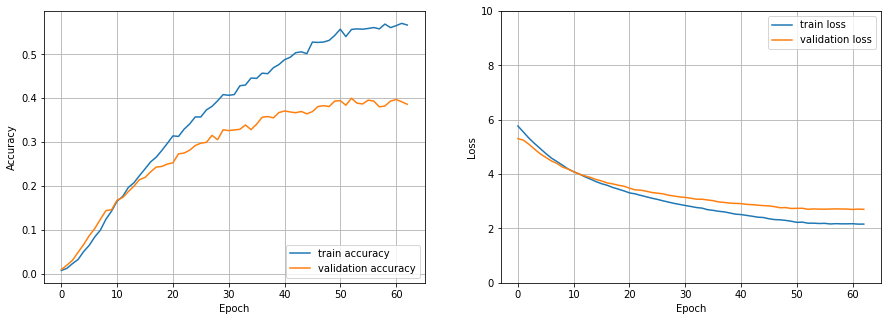

In [17]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(h.history['accuracy'],  label='train accuracy')
plt.plot(h.history['val_accuracy'],  label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'],  label='train loss')
plt.plot(h.history['val_loss'],  label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.ylim([0,10])
plt.legend(loc='upper right')
plt.savefig ("MobileNet_v2_New.pdf",dpi=300)
plt.show()